# FBP Reconstruction of a Sinogram

This notebook demonstrates the performance of the Filtered Back Projection (FBP) algorithm for reconstructing an image from its sinogram.

Step of the process:
1. Create the test problem: we'll use a dataset from a Mayo's Dataset we're going to elaborate it using the `ASTRA Toolbox` library
2. plot the sinogram
3. apply the FBP algorithm and try to achive the best result possible by tuning relevant parameters


### Technical Specifications

| **Implementation Detail** | **U-Net** | **LPP** |
|---------------------------|-----------|---------|
| **Framework** | PyTorch | PyTorch |
| **Device Support** | CUDA GPU | CUDA GPU |
| **Input Format** | FBP reconstructed CT images | FBP reconstructed CT images |
| **Output Format** | Enhanced CT images | Enhanced CT images |
| **Model Files** | FBP_UNET_MODEL.pth | FBP_LPP_MODEL.pth |

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import astra
import utilities

## 1. Creation of the test problem

We're going to create a function to optimize the code and to take a single image from the dataset randomly. The step of the function are going to be:

1. Random selection of an image and plot it
2. Using ASTRA Toolbox to convert it and plot the conversion
## Dataset and Evaluation

| **Aspect** | **Both Models** |
|-------------|----------------|
| **Dataset** | Mayo's Dataset (PNG 512x512) |
| **Training Images** | 3,305 images |
| **Test Images** | 327 images |
| **Preprocessing** | FBP reconstruction with ram-lak filter |
| **Metrics** | SSIM, PSNR, L1 Loss |

In [2]:
def plot_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
def astra_projection(image, angles=180):
    """
    Create sinogram using ASTRA toolbox with fanbeam geometry
    """
    # Convert PyTorch tensor to numpy array
    if torch.is_tensor(image):
        # If it's a 3D tensor (C, H, W), take the first channel
        if len(image.shape) == 3:
            image_np = image[0].cpu().numpy().astype(np.float32)
        else:
            image_np = image.cpu().numpy().astype(np.float32)
    else:
        image_np = np.array(image, dtype=np.float32)
    
    # Ensure we have a 2D array
    if len(image_np.shape) != 2:
        raise ValueError(f"Expected 2D array, got shape {image_np.shape}")

    image = image_np
    # 1. Creating the volume geometry
    vol_geom = astra.create_vol_geom(image_np.shape[0], image_np.shape[1])

    # 2. Creating the projection geometry

    detector_width = 768      # Esempio: Numero di pixel nel detector
    num_angles = 180          # Numero di proiezioni (come richiesto)
    # Angoli da 0 a 180 gradi (np.pi)
    angles = np.linspace(0, np.pi, num_angles, False)

    # Parametri specifici per la fanbeam
    dist_source_origin = 1000  # Distanza sorgente -> centro (DSO)
    dist_origin_detector = 500 # Distanza centro -> detector (DOD)

    proj_geom = astra.create_proj_geom(
        'fanflat',              # type of geometry
        1.0,                    # distance between the centers of two adjacent detector pixels
        detector_width,         # number of detector pixels
        angles,                 # projection angles in radians
        dist_source_origin,     # distance between the source and the center of rotation DSO
        dist_origin_detector    # distance between the center of rotation and the detector array DOD
    )

    # 5. Creation of the projector
    projector_id = astra.create_projector('cuda', proj_geom, vol_geom)

    # 6. Saving ids of the data
    phantom_id = astra.data2d.create('-vol', vol_geom, data=image_np)
    sinogram_id = astra.data2d.create('-sino', proj_geom)

    # 7. Configura l'algoritmo di Forward Projection (FP)
    cfg = astra.astra_dict('FP_CUDA')
    cfg['ProjectorId'] = projector_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['VolumeDataId'] = phantom_id

    # 8. Creation and execution of the algorithm
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # 9. Retrieve the sinogram calculated from ASTRA's memory
    sinogram = astra.data2d.get(sinogram_id)

    astra.algorithm.delete(alg_id)
    astra.data2d.delete(phantom_id)
    astra.projector.delete(projector_id)
    astra.data2d.delete(sinogram_id)
    return sinogram

In [4]:
from pathlib import Path

def load_image(image_path = "Mayo_s Dataset/train", show= True, random = False, count = 0):
    """
    Load an image from the specified path and apply necessary transformations.
    """
    # 1. get all the images paths (changed from .jpg to .png)
    image_path_list = list(Path(image_path).glob("*/*.png"))
    
    if len(image_path_list) == 0:
        print(f"No images found in {image_path}")
        return None
    
    # 2. get a random image
    if not random:
        random_image_path = image_path_list[count]
    else:
        random_image_path = np.random.choice(image_path_list)

    # 3. taking the patient number from the path
    image_class = random_image_path.parent.stem

    # 4. load and transform the image to tensor
    pil_image = Image.open(random_image_path)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    original_image = transform(pil_image)
    if show:
        plot_image(original_image.permute(1, 2, 0), title=f"Loaded Image - Patient {image_class}")
    sinogram = astra_projection(original_image)
    if show:
        plot_image(sinogram, title="Sinogram")
    return original_image, image_class, sinogram

In [5]:
def show_diff(original_image, sinogram):
    """
    Show the difference between the original image and the reconstructed image from the sinogram.
    """
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(sinogram, cmap='gray')
    plt.title("Sinogram")
    plt.axis('off')
    plt.show()
    print(f"ER: {utilities.rel_err(original_image, sinogram)}")
    print(f"PSNR: {utilities.psnr(original_image, sinogram)} dB")
    print(f"SSIM: {utilities.ssim(original_image, sinogram)}")

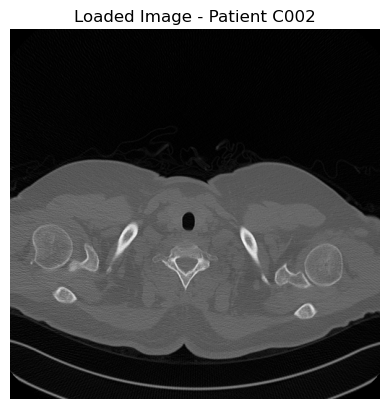

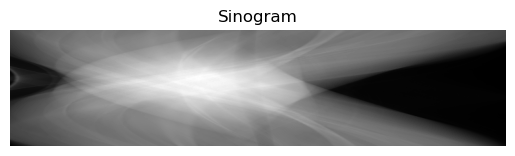

In [6]:
original_image, image_class, sinogram = load_image()

## 2. Applying FBP algorithm

Now that we have our functions to create the test problem we can start trying to adjust recreate our image using the Filtered BackProjection algorithm.

We're going to use the `FBP_CUDA` algorithm given by the `ASTRA` library. To evaluate our results and try to tune the algorithm we're going to use some functions imported from the `utilities.py` file to calculate this metrics:
* Relative Error (RE), to estimate the distance between the original and recostructed image
* peak signal-to-noise ratio (PSNR), used to evaluate the quality of an image. A result above 30-35 point it's acceptable
* The structural similarity index measure (SSIM), is a method for predicting the perceived quality, from 0(high degradation) to 1 (no degradation)

In [7]:
vol_geom = astra.create_vol_geom(original_image.shape[1], original_image.shape[2])
"""
import utilities

# 1. Creating volume geometry

# 2. Reconstruct ID
recon_id = astra.data2d.create('-vol', vol_geom, data=1.0)

# 3. Creating the algorithm for FBP
cfg = astra.astra_dict('FBP_CUDA')
cfg['ProjectionDataId'] = sinogram_id
cfg['ReconstructionDataId'] = recon_id
algorithm_id = astra.algorithm.create(cfg)

# 4. Running the algorithm
astra.algorithm.run(algorithm_id)
# 5. Getting the result
reconstruction = astra.data2d.get(recon_id)
# 6. Plotting the result
show_diff(original_image[0].cpu().numpy().squeeze(), reconstruction)
"""



"\nimport utilities\n\n# 1. Creating volume geometry\n\n# 2. Reconstruct ID\nrecon_id = astra.data2d.create('-vol', vol_geom, data=1.0)\n\n# 3. Creating the algorithm for FBP\ncfg = astra.astra_dict('FBP_CUDA')\ncfg['ProjectionDataId'] = sinogram_id\ncfg['ReconstructionDataId'] = recon_id\nalgorithm_id = astra.algorithm.create(cfg)\n\n# 4. Running the algorithm\nastra.algorithm.run(algorithm_id)\n# 5. Getting the result\nreconstruction = astra.data2d.get(recon_id)\n# 6. Plotting the result\nshow_diff(original_image[0].cpu().numpy().squeeze(), reconstruction)\n"

## 3. Hyperparameters tuning

as we can see the metrics don't give the best results, we're going to tune this specific parameters:
* FilterType, this parameter defines the mathematical filter applied to the sinogram before back-projection. The choice of filter is crucial as it directly controls the trade-off between image sharpness (detail) and noise suppression.
* Filter D, this is a numerical value, typically between 0.0 and 1.0, used to fine-tune filters like Shepp-Logan and Hamming. It acts as a multiplier for the filter's frequency cutoff, allowing for precise control over the filtering strength. A lower value results in more aggressive noise reduction at the cost of some image sharpness.

In [8]:
filter_types = [
    'none',
    'ram-lak',
    'shepp-logan',
    'cosine',
    'hamming',
    'hann',
    'tukey',
    'lanczos',
    'triangular',
    'gaussian',
    'barlett-hann',
    'blackman',
    'nuttall',
    'blackman-harris',
    'blackman-nuttall',
    'flat-top',
    'kaiser',
    'parzen'
]
filter_d_values = np.linspace(0.5, 1.0, 6)
detector_width = 768      # Esempio: Numero di pixel nel detector
num_angles = 180          # Numero di proiezioni (come richiesto)
# Angoli da 0 a 180 gradi (np.pi)
angles = np.linspace(0, np.pi, num_angles, False)

# Parametri specifici per la fanbeam
dist_source_origin = 1000  # Distanza sorgente -> centro (DSO)
dist_origin_detector = 500 # Distanza centro -> detector (DOD)

proj_geom = astra.create_proj_geom(
    'fanflat',              # type of geometry
    1.0,                    # distance between the centers of two adjacent detector pixels
    detector_width,         # number of detector pixels
    angles,                 # projection angles in radians
    dist_source_origin,     # distance between the source and the center of rotation DSO
    dist_origin_detector    # distance between the center of rotation and the detector array DOD
)

In [9]:
def normalize(image):
    """Normalizza un'immagine nel range [0, 1]."""
    min_val = image.min()
    max_val = image.max()
    if max_val > min_val:
        return (image - min_val) / (max_val - min_val)
    return image

In [10]:
epochs = 1
filter_counter = {} # counts how many times each filter was best
for epoch in range(epochs):
    # Find the best filter type analyzing different images
    original_image, image_class, sinogram = load_image(show=False, random=True)
    print(f"\n========= EPOCH {epoch+1}/{epochs} =========")
    print(f"Patient: {image_class}")
    results = []
    best_score_ssim = -1
    best_params_ssim = None
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)

    for filter in filter_types:
        # 1. Creating the algorithm for FBP
        recon_id = astra.data2d.create('-vol', vol_geom, data=1.0)
        cfg = astra.astra_dict('FBP_CUDA')
        cfg['ProjectionDataId'] = sinogram_id
        cfg['ReconstructionDataId'] = recon_id
        cfg['option'] = {"FilterType":filter}
        algorithm_id = astra.algorithm.create(cfg)

        # 2. Running the algorithm
        astra.algorithm.run(algorithm_id)
        
        # 3. Getting the result
        reconstruction = astra.data2d.get(recon_id)
        relative_error = utilities.rel_err(normalize(reconstruction), normalize(original_image[0].cpu().numpy()))
        psnr = utilities.psnr(normalize(reconstruction), normalize(original_image[0].cpu().numpy()))
        ssim = utilities.ssim(normalize(reconstruction), normalize(original_image[0].cpu().numpy()))
        # 4. Comparing metrics
        results.append({
        'params': {"FilterType":filter},
        'psnr': psnr,
        'ssim': ssim,
        're': relative_error
        })
        if ssim > best_score_ssim:
            best_score_ssim = ssim
            best_params_ssim = {"FilterType":filter}
            best_reconstruction_ssim = reconstruction
        

        #6. Cleaning memory
        astra.data2d.delete(recon_id)
        astra.algorithm.delete(algorithm_id)
    if epochs <= 0:
        show_diff(original_image[0].cpu().numpy().squeeze(), best_reconstruction_ssim)
        print(f"Best params (SSIM): {best_params_ssim}")
    filter_counter[best_params_ssim['FilterType']] = filter_counter.get(best_params_ssim['FilterType'], 0) + 1
    astra.data2d.delete(sinogram_id)
print(f"--- TUNING RESULTS ---")
print(f"best filters : {filter_counter}")
print(f"end=epoch {epoch+1}/{epochs}")


========= EPOCH 1/1 =========
Patient: C077
--- TUNING RESULTS ---
best filters : {'shepp-logan': 1}
end=epoch 1/1


As we can see the FBP recustruction alone is not enogh to obtain a good recostruction of our sinogram. To imrove our recostruction we're going to use a U-net.

## 4. Training a U-net to improve the image quality.

Our pipeline to train our model will be:
1. get the real image and turn it into a sinogram
2. start the recostruction of a sinogram and create our list of images to give to our model
3. take the real images and turn them into a dataset to give them as label for tuning the parameters of the neural network
4. create model, loss and optimizer
5. train the model
6. evaluate the model

### 4.1 Turning the dataset into sinograms

In [11]:
sinogram.dtype, original_image.dtype

(dtype('float32'), torch.float32)

In [12]:
from tqdm import tqdm
original_images_train_list = []
sinograms_train_list = []
for i in tqdm(range(3305),  desc="Processing images", unit="img"):
    original_image, image_class, sinogram = load_image(count=i, show=False)
    original_images_train_list.append(original_image)
    sinograms_train_list.append(sinogram)

Processing images: 100%|██████████| 3305/3305 [02:01<00:00, 27.18img/s]


In [13]:
from tqdm import tqdm
original_images_test_list = []
sinograms_test_list = []
for i in tqdm(range(327),  desc="Processing images", unit="img"):
    original_image, image_class, sinogram = load_image(image_path="Mayo_s Dataset/test",count=i, show=False)
    original_images_test_list.append(original_image)
    sinograms_test_list.append(sinogram)

Processing images: 100%|██████████| 327/327 [00:07<00:00, 45.43img/s]


### 4.2 Creating our real train, test images

Now that we have our sinograms, let's apply FBP to recreate the image using the ... parameter

In [14]:
# Train images
FBP_rebuilt_images_train_list = []
for i in tqdm(range(3305), desc="Processing train sinograms", unit="img"):
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinograms_train_list[i])
    recon_id = astra.data2d.create('-vol', vol_geom, data=1.0)
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ReconstructionDataId'] = recon_id
    cfg['option'] = {"FilterType":"ram-lak"}
    algorithm_id = astra.algorithm.create(cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data2d.get(recon_id)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    FBP_rebuilt_images_train_list.append(transform(reconstruction))
    astra.data2d.delete(recon_id)
    astra.data2d.delete(sinogram_id)
    astra.algorithm.delete(algorithm_id)

Processing train sinograms: 100%|██████████| 3305/3305 [00:21<00:00, 155.19img/s]


In [15]:
# Test images
FBP_rebuilt_images_test_list = []
for i in tqdm(range(327), desc="Processing test sinograms", unit="img"):
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinograms_test_list[i])
    recon_id = astra.data2d.create('-vol', vol_geom, data=1.0)
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ReconstructionDataId'] = recon_id
    cfg['option'] = {"FilterType":"ram-lak"}
    algorithm_id = astra.algorithm.create(cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data2d.get(recon_id)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    FBP_rebuilt_images_test_list.append(transform(reconstruction))
    astra.data2d.delete(recon_id)
    astra.data2d.delete(sinogram_id)
    astra.algorithm.delete(algorithm_id)

Processing test sinograms: 100%|██████████| 327/327 [00:02<00:00, 149.12img/s]


### 4.3 Dataset and Dataloader

In [16]:
from torch.utils.data import Dataset, DataLoader

class CTDataset(Dataset):
    def __init__(self, image_path: str, filter_type="ram-lak", proj_geom=None):
        super().__init__()
        self.image_paths = sorted(list(Path(image_path).glob("*/*.png")))
        self.filter_type = filter_type
        self.vol_geom = astra.create_vol_geom(512, 512)
        self.proj_geom = proj_geom
        self.to_tensor = transforms.ToTensor()
    def __len__(self)-> int:
        return len(self.image_paths)

    def __getitem__(self, idx:int)->tuple[torch.Tensor, torch.Tensor]:
        image_path = self.image_paths[idx]
        pil_image = Image.open(image_path).convert("L") 
        original_image_tensor = self.to_tensor(pil_image)
        sinogram = astra_projection(original_image_tensor)
        sinogram_id = astra.data2d.create('-sino', self.proj_geom, data=sinogram)
        recon_id = astra.data2d.create('-vol', self.vol_geom, data=1.0)
        cfg = astra.astra_dict('FBP_CUDA')
        cfg['ProjectionDataId'] = sinogram_id
        cfg['ReconstructionDataId'] = recon_id
        cfg['option'] = {"FilterType": self.filter_type}
        
        algorithm_id = astra.algorithm.create(cfg)
        astra.algorithm.run(algorithm_id)
        reconstruction = astra.data2d.get(recon_id)
        fbp_image_tensor = self.to_tensor(reconstruction.astype(np.float32))
        astra.data2d.delete([recon_id, sinogram_id])
        astra.algorithm.delete(algorithm_id)
        return fbp_image_tensor, original_image_tensor

In [17]:
BATCH_SIZE = 8
NUM_WORKERS = 0

train_data = CTDataset(image_path="Mayo_s Dataset/train", proj_geom=proj_geom) 
test_data = CTDataset(image_path="Mayo_s Dataset/test", proj_geom=proj_geom)

In [18]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

img_custom, label_custom = next(iter(train_dataloader))
img_custom.shape, label_custom.shape

(torch.Size([8, 1, 512, 512]), torch.Size([8, 1, 512, 512]))

### 4.3 Building the model

https://medium.com/data-science/cook-your-first-u-net-in-pytorch-b3297a844cf3

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
import torch
import torch.nn as nn

class UNet_V1(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU()
            )
        # --- Encoder ---
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- Bottleneck ---
        self.bottleneck = conv_block(128, 256)

        # --- Decoder ---
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = conv_block(256, 128) # Canali: 128 (da upconv) + 128 (da enc3)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)  # Canali: 64 (da upconv) + 64 (da enc2)

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec3 = conv_block(64, 32)

        # --- Output ---
        self.outconv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        s1 = self.enc1(x)
        p1 = self.pool1(s1)

        s2 = self.enc2(p1)
        p2 = self.pool2(s2)

        s3 = self.enc3(p2)
        p3 = self.pool3(s3)
        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        d1 = self.upconv1(b)
        d1 = torch.cat([d1, s3], dim=1)
        d1 = self.dec1(d1)

        d2 = self.upconv2(d1)
        d2 = torch.cat([d2, s2], dim=1)
        d2 = self.dec2(d2)

        d3 = self.upconv3(d2)
        d3 = torch.cat([d3, s1], dim=1)
        d3 = self.dec3(d3)

        # Output
        out = self.outconv(d3)
        return out

In [21]:
model_1 = UNet_V1(in_channels=1, out_channels=1)


In [22]:
loss_fn1 = torch.nn.L1Loss()
optimizer1 = torch.optim.Adam(params=model_1.parameters(), lr=1e-4)

### 4.3 Training and testing loop

In [23]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float, 
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end-start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [24]:
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    """Performs a training with model trying to learn on data_loader."""
    
    ### training 
    train_loss = 0
    model.train()
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # accumulate train los
        ssim_metric.update(y_pred, y)
        psnr_metric.update(y_pred, y)
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()


    # Divide total train loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    final_ssim = ssim_metric.compute()
    final_psnr = psnr_metric.compute()
    print(f"Train loss: {train_loss:.5f} | Train SSIM: {final_ssim:.4f} | Train PSNR: {final_psnr:.2f} dB")

In [25]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    
    """Performs a testing loop step on model going over data_loader."""

    test_loss = 0
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate the loss
            test_loss += loss_fn(test_pred, y).item()

            # 3. Calculate accuracy
            ssim_metric.update(test_pred, y)
            psnr_metric.update(test_pred, y)
        
        # Calculate the test loss average per batch
        test_loss /= len(data_loader)

        # Calculate the test acc average per batch
        final_ssim = ssim_metric.compute()
        final_psnr = psnr_metric.compute()
        # Print out what's happening
        print(f"\nTest loss: {test_loss:.4f} | Test SSIM: {final_ssim:.4f} | Test PSNR: {final_psnr:.2f} dB \n")

In [26]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [27]:
from tqdm.auto import tqdm
n_epochs = 5

torch.manual_seed(42)
train_time_start_on_gpu = timer()
model_1.to(device)
for epoch in tqdm(range(n_epochs)):
    print(f"Epoch: {epoch+1} / {n_epochs}\n-------------------------------")
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn1,
               optimizer=optimizer1,
               device=device)
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn1,
              device=device)
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 / 5
-------------------------------
Train loss: 0.06318 | Train SSIM: 0.5223 | Train PSNR: 19.00 dB

Test loss: 0.0299 | Test SSIM: 0.6927 | Test PSNR: 24.93 dB 

Epoch: 2 / 5
-------------------------------
Train loss: 0.03108 | Train SSIM: 0.6720 | Train PSNR: 25.04 dB

Test loss: 0.0229 | Test SSIM: 0.7612 | Test PSNR: 27.22 dB 

Epoch: 3 / 5
-------------------------------
Train loss: 0.02610 | Train SSIM: 0.7179 | Train PSNR: 26.51 dB

Test loss: 0.0218 | Test SSIM: 0.7877 | Test PSNR: 27.65 dB 

Epoch: 4 / 5
-------------------------------
Train loss: 0.02386 | Train SSIM: 0.7402 | Train PSNR: 27.24 dB

Test loss: 0.0195 | Test SSIM: 0.8024 | Test PSNR: 28.44 dB 

Epoch: 5 / 5
-------------------------------
Train loss: 0.02229 | Train SSIM: 0.7560 | Train PSNR: 27.81 dB

Test loss: 0.0185 | Test SSIM: 0.8149 | Test PSNR: 28.69 dB 

Train time on cuda: 987.746 seconds


### 4.4 saving our model

In [28]:
# Saving out PyTorch module\
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "FBP_UNET_MODEL.pth"
MODEL1_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save te model state dict
print(f"Saving the model to:{MODEL1_SAVE_PATH}...")
torch.save(obj=model_1.state_dict(), 
           f=MODEL1_SAVE_PATH)
print("model saved!")

Saving the model to:models\FBP_UNET_MODEL.pth...
model saved!


### 4.5 Make predictions

In [29]:
loaded_model = UNet_V1(in_channels=1, out_channels=1)
loaded_model.load_state_dict(torch.load(MODEL1_SAVE_PATH))
loaded_model.to(device)
loaded_model.eval()  # Imposta il modello in modalità valutazione
print(f"Modello U-Net caricato con successo da: {MODEL1_SAVE_PATH}")

Modello U-Net caricato con successo da: models\FBP_UNET_MODEL.pth


C:\Users\jonas\AppData\Local\Temp\ipykernel_14200\2634968811.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL1_SAVE_PATH))


In [30]:
# Load a random image and its sinogram
random_image,image_class, sinogram = load_image(show=False, random=True)

In [31]:
# Perform FBP reconstruction using ASTRA
sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
recon_id = astra.data2d.create('-vol', vol_geom, data=1.0)
cfg = astra.astra_dict('FBP_CUDA')
cfg['ProjectionDataId'] = sinogram_id
cfg['ReconstructionDataId'] = recon_id
cfg['option'] = {"FilterType":"ram-lak"}
algorithm_id = astra.algorithm.create(cfg)
astra.algorithm.run(algorithm_id)
reconstruction = astra.data2d.get(recon_id)
transform = transforms.Compose([
        transforms.ToTensor()
    ])

astra.data2d.delete(recon_id)
astra.data2d.delete(sinogram_id)
astra.algorithm.delete(algorithm_id)

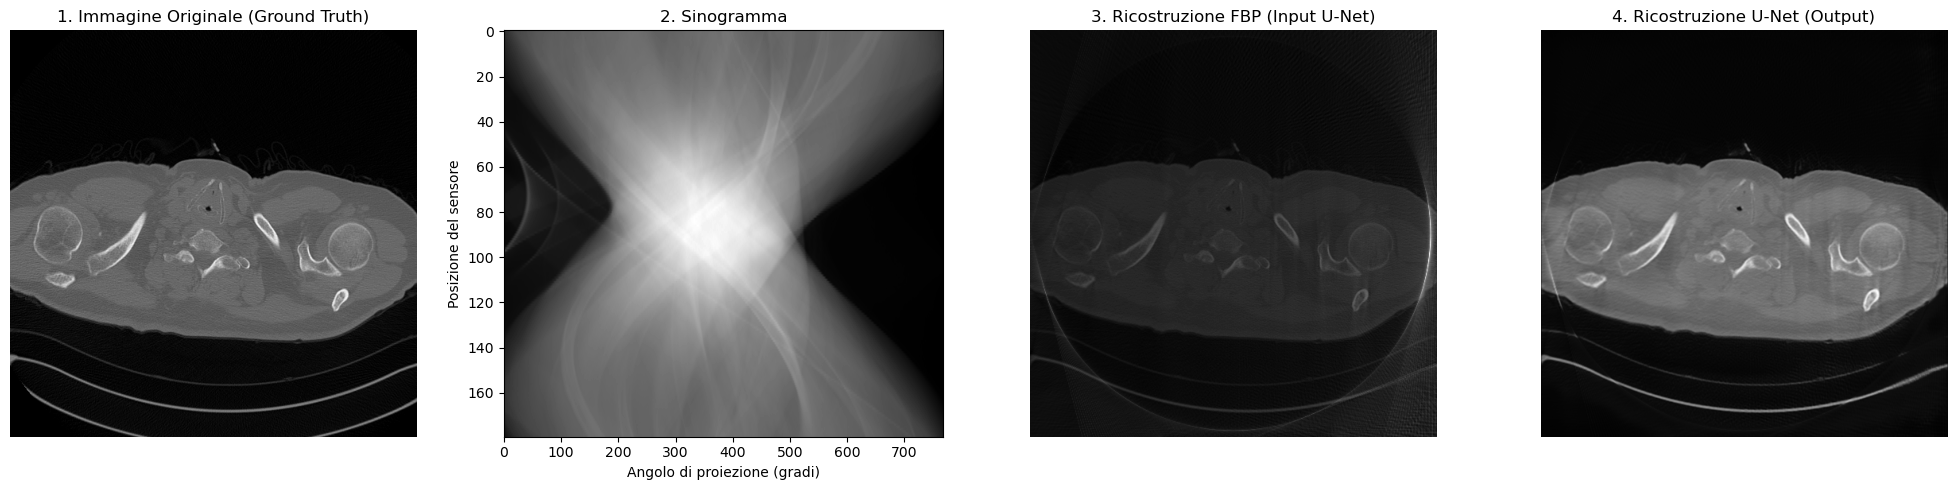

In [32]:
# Making our reconstruction ready for the model
fbp_tensor = torch.from_numpy(reconstruction).unsqueeze(0).unsqueeze(0).float().to(device)
with torch.inference_mode():
    unet_output_tensor = loaded_model(fbp_tensor)
unet_reconstruction_np = unet_output_tensor.squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(random_image[0].cpu().numpy().squeeze(), cmap='gray')
axes[0].set_title("1. Immagine Originale (Ground Truth)")
axes[0].axis('off')

# Sinogram
axes[1].imshow(sinogram, cmap='gray', aspect='auto')
axes[1].set_title("2. Sinogramma")
axes[1].set_xlabel("Angolo di proiezione (gradi)")
axes[1].set_ylabel("Posizione del sensore")

# FBP reconstruction
axes[2].imshow(reconstruction, cmap='gray')
axes[2].set_title("3. Ricostruzione FBP (Input U-Net)")
axes[2].axis('off')

# U-net reconstruction
axes[3].imshow(unet_reconstruction_np, cmap='gray')
axes[3].set_title("4. Ricostruzione U-Net (Output)")
axes[3].axis('off')

plt.tight_layout()
plt.show()


## 5. Learned Post-Processing

As explained in the paper available at https://www.mdpi.com/2313-433X/7/8/139, it is possible to create an effective neural network that is less sophisticated than architectures like ResUNet. Following this principle, we propose a simple model composed of a sequence of three inner layers:
1. Conv2D
2. BatchNormalization
3. ReLU block

This model does not employ an encoder-decoder structure; instead, it operates as a single-scale model, processing the input without changing its spatial dimensions. For training, we will use Mean Squared Error (MSE) as the loss function and Adam as the optimizer.

In [37]:
import torch
print(f"Memoria GPU allocata: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Memoria GPU riservata: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
print(f"Memoria GPU massima allocata: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")

# Libera la cache
torch.cuda.empty_cache()
print("Cache GPU liberata")

Memoria GPU allocata: 0.08 GB
Memoria GPU riservata: 8.50 GB
Memoria GPU massima allocata: 4.12 GB
Cache GPU liberata


### 5.1 Building our LPP model

In [38]:
import torch
import torch.nn as nn

class LPP_model(nn.Module):
    def __init__(self):
        super(LPP_model, self).__init__()
        # Define your model architecture here
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [39]:
model_2 = LPP_model()

In [40]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=1e-4)

In [41]:
from tqdm.auto import tqdm
n_epochs = 5

torch.manual_seed(42)
train_time_start_on_gpu = timer()
model_2.to(device)
for epoch in tqdm(range(n_epochs)):
    print(f"Epoch: {epoch+1} / {n_epochs}\n-------------------------------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              device=device)
train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 / 5
-------------------------------
Train loss: 0.02237 | Train SSIM: 0.2675 | Train PSNR: 16.50 dB

Test loss: 0.0076 | Test SSIM: 0.3568 | Test PSNR: 21.20 dB 

Epoch: 2 / 5
-------------------------------
Train loss: 0.00901 | Train SSIM: 0.3874 | Train PSNR: 20.46 dB

Test loss: 0.0057 | Test SSIM: 0.4019 | Test PSNR: 22.43 dB 

Epoch: 3 / 5
-------------------------------
Train loss: 0.00747 | Train SSIM: 0.4206 | Train PSNR: 21.27 dB

Test loss: 0.0052 | Test SSIM: 0.4504 | Test PSNR: 22.83 dB 

Epoch: 4 / 5
-------------------------------
Train loss: 0.00660 | Train SSIM: 0.4373 | Train PSNR: 21.80 dB

Test loss: 0.0049 | Test SSIM: 0.4330 | Test PSNR: 23.10 dB 

Epoch: 5 / 5
-------------------------------
Train loss: 0.00613 | Train SSIM: 0.4467 | Train PSNR: 22.13 dB

Test loss: 0.0039 | Test SSIM: 0.4692 | Test PSNR: 24.06 dB 

Train time on cuda: 875.362 seconds


In [42]:
# Saving out PyTorch module\
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "FBP_LPP_MODEL.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save te model state dict
print(f"Saving the model to:{MODEL_SAVE_PATH}...")
torch.save(obj=model_2.state_dict(), 
           f=MODEL_SAVE_PATH)
print("model saved!")

Saving the model to:models\FBP_LPP_MODEL.pth...
model saved!


In [46]:
lpp_model = LPP_model()
lpp_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
lpp_model.to(device)
lpp_model.eval()  # Imposta il modello in modalità valutazione
print(f"Modello LPP caricato con successo da: {MODEL_SAVE_PATH}")

Modello LPP caricato con successo da: models\FBP_LPP_MODEL.pth


C:\Users\jonas\AppData\Local\Temp\ipykernel_14200\4112136200.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lpp_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


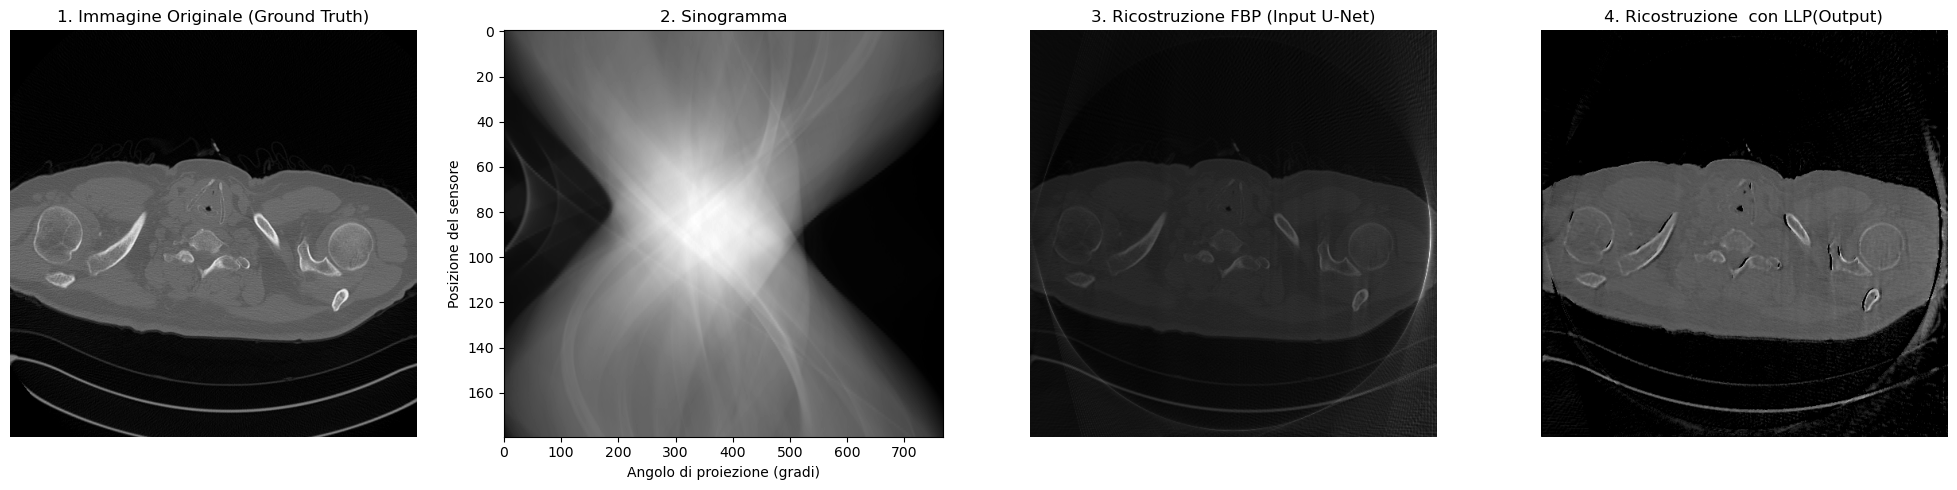

In [47]:
with torch.inference_mode():
    unet_output_tensor = lpp_model(fbp_tensor)
LLP_reconstruction_np = unet_output_tensor.squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(random_image[0].cpu().numpy().squeeze(), cmap='gray')
axes[0].set_title("1. Immagine Originale (Ground Truth)")
axes[0].axis('off')

# Sinogram
axes[1].imshow(sinogram, cmap='gray', aspect='auto')
axes[1].set_title("2. Sinogramma")
axes[1].set_xlabel("Angolo di proiezione (gradi)")
axes[1].set_ylabel("Posizione del sensore")

# FBP reconstruction
axes[2].imshow(reconstruction, cmap='gray')
axes[2].set_title("3. Ricostruzione FBP (Input U-Net)")
axes[2].axis('off')

# U-net reconstruction
axes[3].imshow(LLP_reconstruction_np, cmap='gray')
axes[3].set_title("4. Ricostruzione  con LLP(Output)")
axes[3].axis('off')

plt.tight_layout()
plt.show()

## 6. Evaluation and conclusion of the notebook


### Comparative Table

| **Characteristic** | **U-Net** | **LPP (Learned Post-Processing)** |
|-------------------|-----------|----------------------------------|
| **Architecture** | Encoder-Decoder with skip connections | Sequential CNN (3 layers) |
| **Structure Type** | Multi-scale (downsampling + upsampling) | Single-scale (same resolution) |
| **Number of Layers** | 19 layers (encoder + decoder + bottleneck) | 9 layers |
| **Channels per Layer** | 1 → 32 → 64 → 128 → 256 → 128 → 64 → 32 → 1 | 1 → 128 → 64 → 1 |
| **Skip Connections** |  Yes (encoder-decoder concatenation) |  No |
| **Pooling/Upsampling** |  MaxPool2d + ConvTranspose2d |  None |

### Training Configuration

| **Parameter** | **U-Net** | **LPP** |
|---------------|-----------|---------|
| **Loss Function** | L1Loss (MAE) | MSELoss |
| **Optimizer** | Adam (lr=1e-4) | Adam (lr=1e-4) |
| **Epochs** | 5 | 5 |
| **Batch Size** | 8 | 8 |
| **Input/Output Channels** | 1 → 1 | 1 → 1 |

### Model Complexity

| **Metric** | **U-Net** | **LPP** |
|-------------|-----------|---------|
| **Estimated Parameters** | ~1.9M parameters | ~73K parameters |
| **GPU Memory Required** | High (encoder-decoder) | Low (sequential) |
| **Training Speed** | Slower | Faster |
| **Inference Speed** | Slower | Faster |

### Architectural Features

#### U-Net
- **Advantages:**
  - Skip connections preserve fine details
  - Multi-scale feature extraction
  - Well-established architecture for medical imaging
  - Better for capturing complex structures

- **Disadvantages:**
  - Higher computational complexity
  - More parameters to optimize
  - Higher GPU memory usage

#### LPP (Learned Post-Processing)
- **Advantages:**
  - Simple and fast architecture
  - Fewer parameters (more efficient)
  - Lower memory usage
  - Faster training

- **Disadvantages:**
  - No skip connections (potential detail loss)
  - Single-scale processing
  - Potentially less effective on complex structures


### Performance Expectations

| **Quality Metric** | **U-Net** | **LPP** |
|-------------------|-----------|---------|
| **Image Quality** | Higher (due to skip connections) | Good (single-scale processing) |
| **Detail Preservation** | Excellent | Good |
| **Artifact Reduction** | Very Good | Good |
| **Processing Time** | Slower | Faster |
| **Memory Efficiency** | Lower | Higher |

### Real Performance comparison after 5 epochs
| **Quality Metric** | **U-Net** | **LPP** |
|-------------------|-----------|---------|
| **Training time** |987.746 seconds | 875.362 seconds |
| **Test Loss** | 0.0185 | 0.0049 |
| **PSNR** | 28.69 dB | 24.06 dB |
| **SSIM** | 0.8149 | 0.4692 |

### Conclusions
Despite the LPP model's slightly faster training time (875s vs. 987s), the U-Net architecture delivered vastly superior image quality.

The U-Net's significantly higher PSNR (28.69 dB vs. 24.06 dB) and SSIM (0.8149 vs. 0.4692) scores clearly indicate a better reconstruction with more preserved detail. In our 5-epoch test, the U-Net yielded superior results with only a minimal increase in training time. This was an exploratory run designed to help us understand these algorithms for a benchmarking tool we are developing in our traineeship. The goal was not to train a perfect model. We expect that over more epochs, the time difference would widen and the LPP's performance could improve.

